In [1]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

from mne.io import concatenate_raws, read_raw_edf
import antropy as ant
import mne
import mne_features
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [2]:
participants = pd.read_csv("/Users/utkarsh.lal/Desktop/Parkinson's Disease/Parkinsons-EEG-DeepLearning/Parkinson's disease dataset/participants.tsv", sep='\t')
participants

participant_id  age gender hand  MMSE  NAART  disease_duration  \
0         sub-hc1   54      f    r    30     48               NaN   
1         sub-hc2   50      f    r    30     55               NaN   
2         sub-pd3   52      f    r    29     44               9.0   
3         sub-hc4   50      f    r    30     52               NaN   
4         sub-pd5   67      f    r    29     48               2.0   
5         sub-pd6   62      f    r    30     42               8.0   
6         sub-hc7   54      f    r    26     48               NaN   
7         sub-hc8   71      f    r    29     41               NaN   
8         sub-pd9   55      f    r    28     50              12.0   
9        sub-hc10   59      f    r    29     51               NaN   
10       sub-pd12   74      m    r    26     53               1.0   
11       sub-pd11   71      f    r    30     52               1.0   
12       sub-pd13   62      m    r    29     47               2.0   
13       sub-pd14   63      m    r    28     35               2.0   
14       sub-pd16   74      m    r    29     56               2.0   
15       sub-pd17   55      m    r    30     40               2.0   
16       sub-hc18   57      m    r    30     57               NaN   
17       sub-pd19   69      f    r    29     43               6.0   
18       sub-hc20   68      m    r    30     58               NaN   
19       sub-hc21   72      m    r    28     33               NaN   
20       sub-pd22   47      m    r    30     51               6.0   
21       sub-pd23   66      f    r    29     34               3.0   
22       sub-hc24   61      f    r    30     57               NaN   
23       sub-hc25   74      f    r    30     49               NaN   
24       sub-pd26   71      f    r    29     51               3.0   
25       sub-pd28   61      m    r    29     46               9.0   
26       sub-hc29   60      f    r    29     45               NaN   
27       sub-hc30   69      m    r    29     52               NaN   
28       sub-hc31   82      m    r    28     50               NaN   
29       sub-hc32   60      m    r    29     37               NaN   
30       sub-hc33   75      m    r    30     53               NaN   

                                          rl_deficits  \
0                                                 NaN   
1                                                 NaN   
2                                                   R   
3                                                 NaN   
4                       No clear side, perhaps more L   
5                          L OFF meds, more R ON meds   
6                                                 NaN   
7                                                 NaN   
8                                                   R   
9                                                 NaN   
10                                                NaN   
11                                        R worse off   
12                                   R slightly worse   
13                                        R worse off   
14           Started on left, noticed left side worse   
15                 started on R; Right slightly worse   
16                                                NaN   
17                started on Left side, left is worse   
18                                                NaN   
19                                                NaN   
20                started on Left side, left is worse   
21                        started on L, left is worse   
22                                                NaN   
23                                                NaN   
24  started L leg tremor, then moved to right arm ...   
25                started on right, but left is worse   
26                                                NaN   
27                                                NaN   
28                                                NaN   
29                                                NaN   
30                         

In [22]:
subject = "sub-pd14"
path = f"/Users/utkarsh.lal/Desktop/Parkinson's Disease/Parkinsons-EEG-DeepLearning/Parkinson's disease dataset/PD/{subject}/"
filename = f"ses-ON/eeg/{subject}_ses-on_task-rest_eeg.bdf"

In [23]:
EEG_data = mne.io.read_raw_bdf(f"{path}{filename}", preload=True)
EEG_data

Extracting EDF parameters from /Users/utkarsh.lal/Desktop/Parkinson's Disease/Parkinsons-EEG-DeepLearning/Parkinson's disease dataset/PD/sub-pd14/ses-ON/eeg/sub-pd14_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96767  =      0.000 ...   188.998 secs...


<RawEDF | sub-pd14_ses-on_task-rest_eeg.bdf, 41 x 96768 (189.0 s), ~30.3 MB, data loaded>

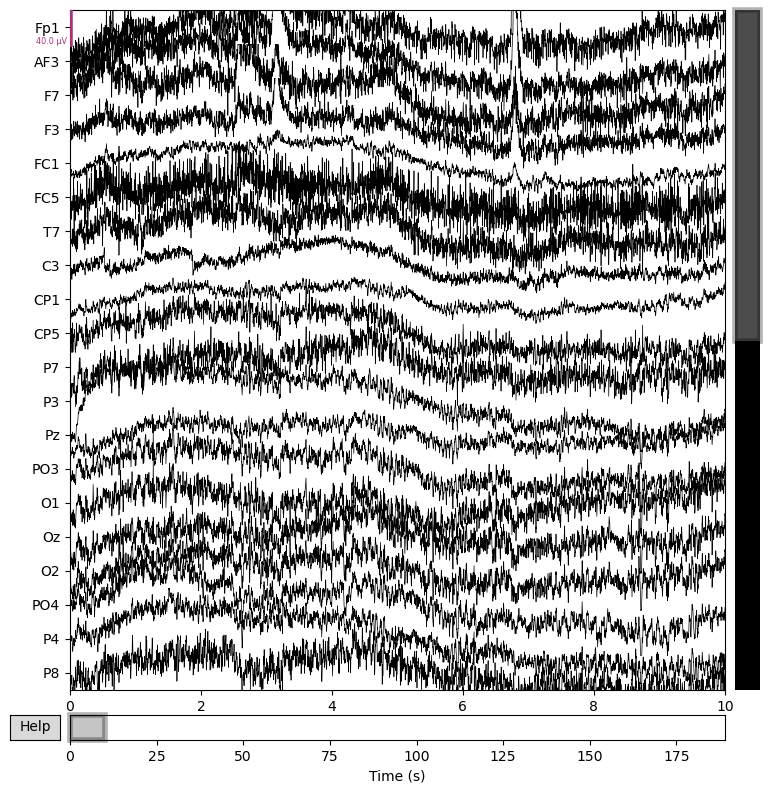

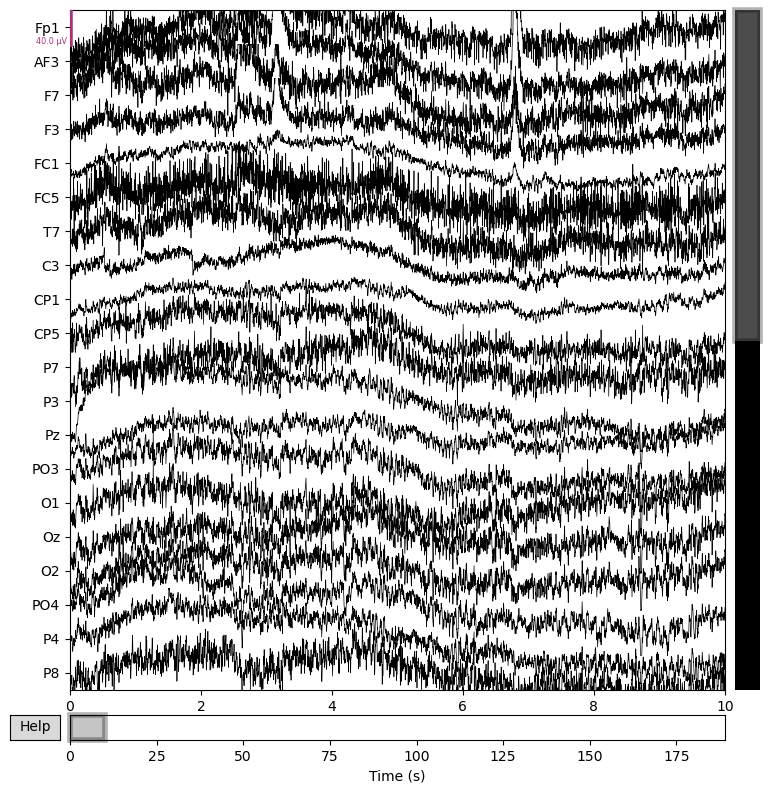

In [24]:
EEG_data.plot()

In [25]:
low_freq, high_freq = 1.0, 40.0 # values in Hz
raw = EEG_data.copy().filter(low_freq, high_freq, n_jobs=4)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.1s finished


In [26]:
raw.crop(tmax=150)

<RawEDF | sub-pd14_ses-on_task-rest_eeg.bdf, 41 x 76801 (150.0 s), ~24.1 MB, data loaded>

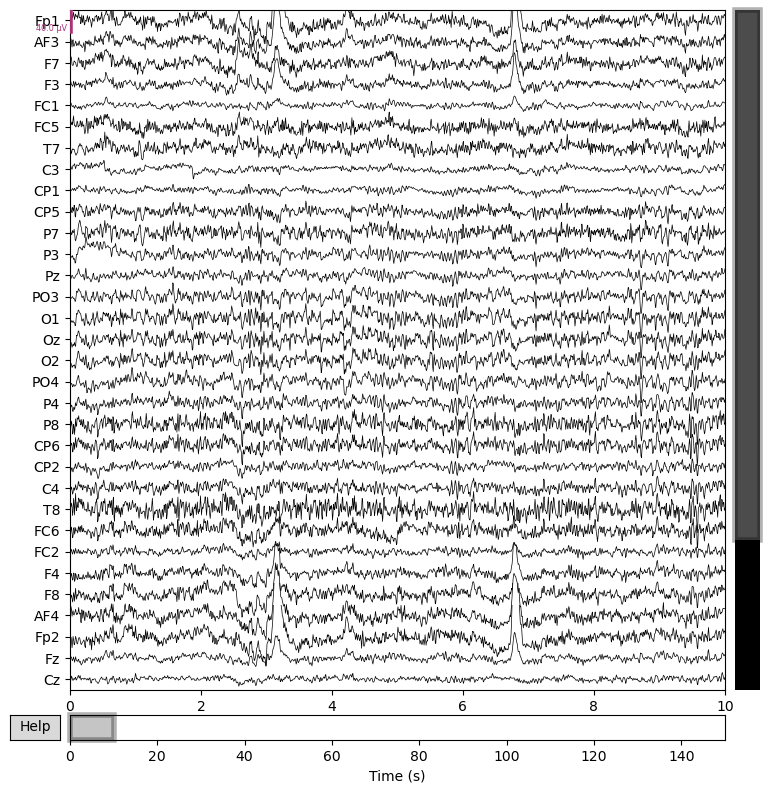

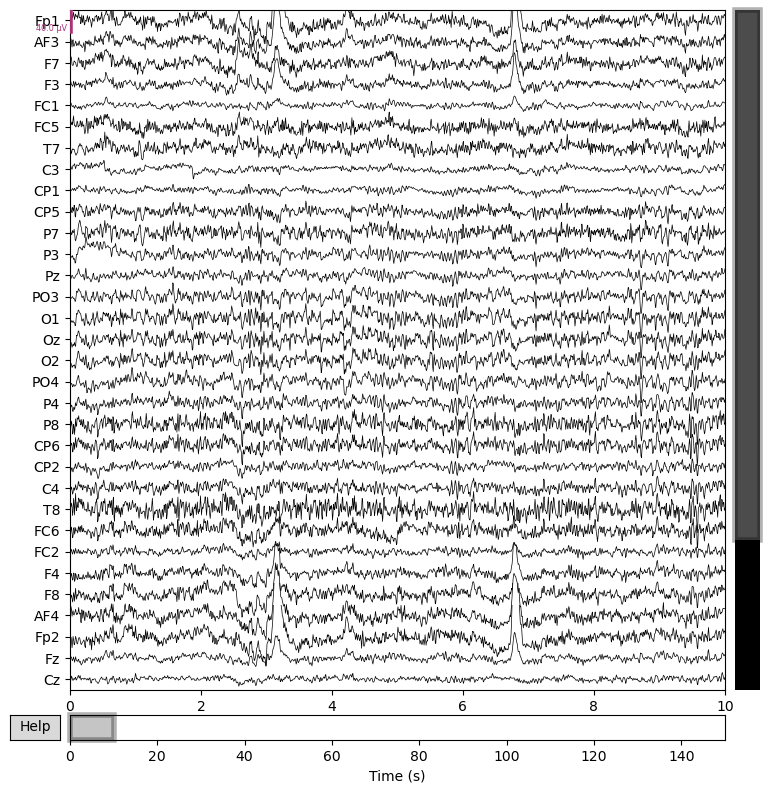

In [27]:
raw.plot(n_channels = 32)

In [28]:
raw = raw.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status'])

In [29]:
std_montage = mne.channels.make_standard_montage('biosemi32')
raw.set_montage(std_montage)

<RawEDF | sub-pd14_ses-on_task-rest_eeg.bdf, 32 x 76801 (150.0 s), ~18.8 MB, data loaded>

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 6.9s.


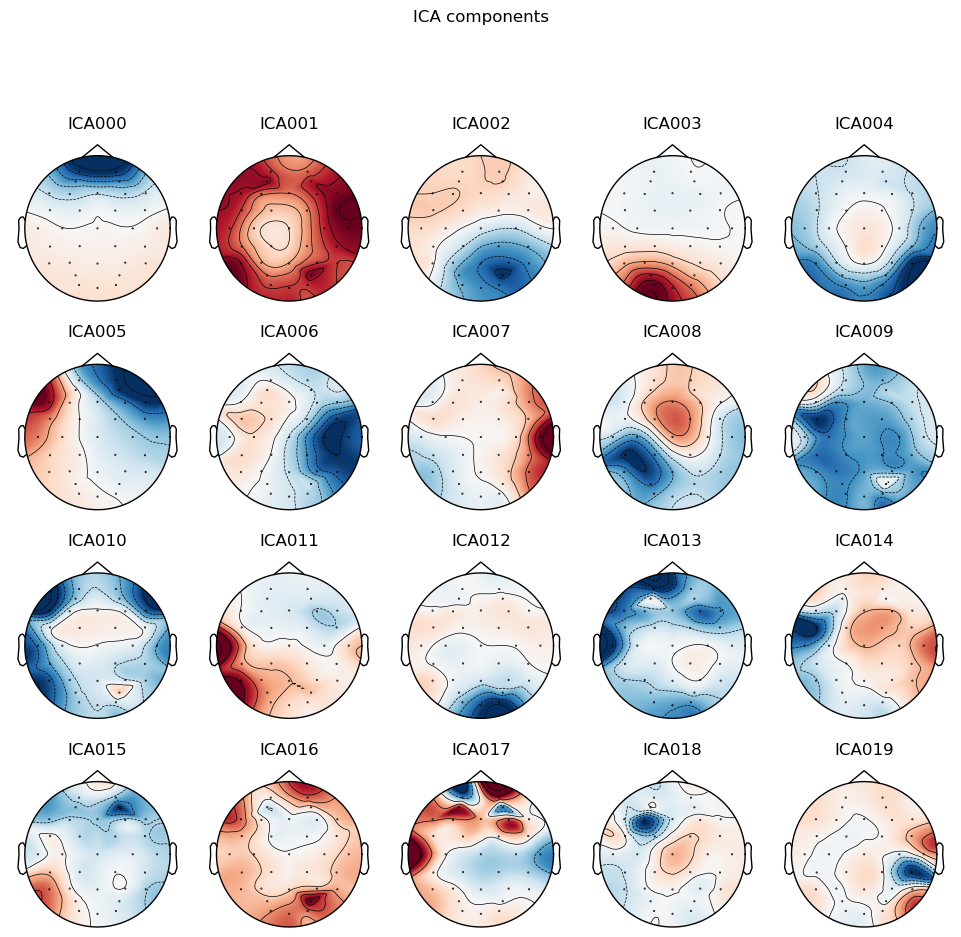

[<MNEFigure size 975x967 with 20 Axes>]

In [30]:
ica = mne.preprocessing.ICA(n_components=20, random_state=0)
ica.fit(raw.copy())
ica.plot_components()

Using EOG channels: Fp2, F8
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


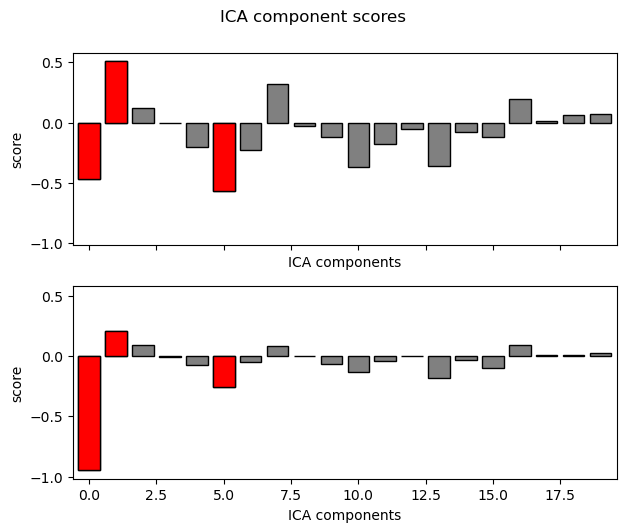

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated


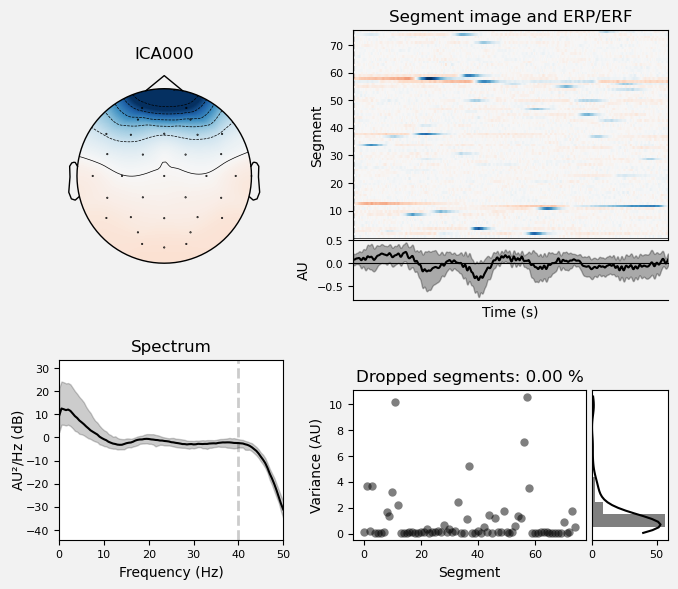

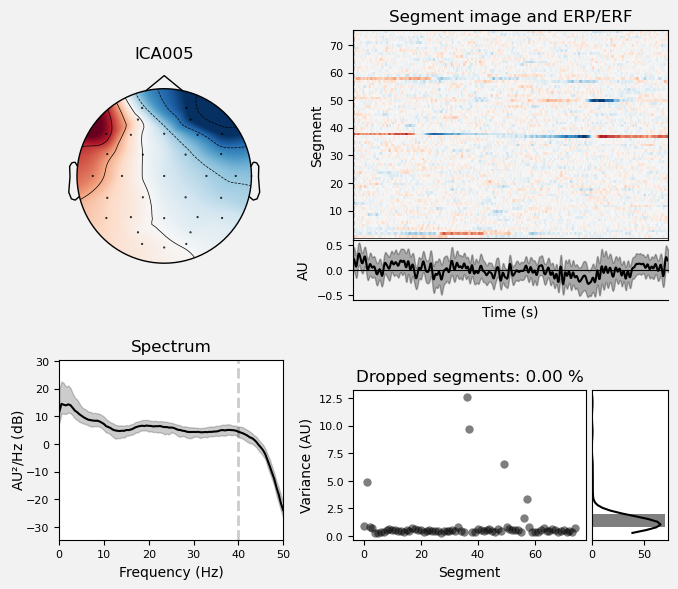

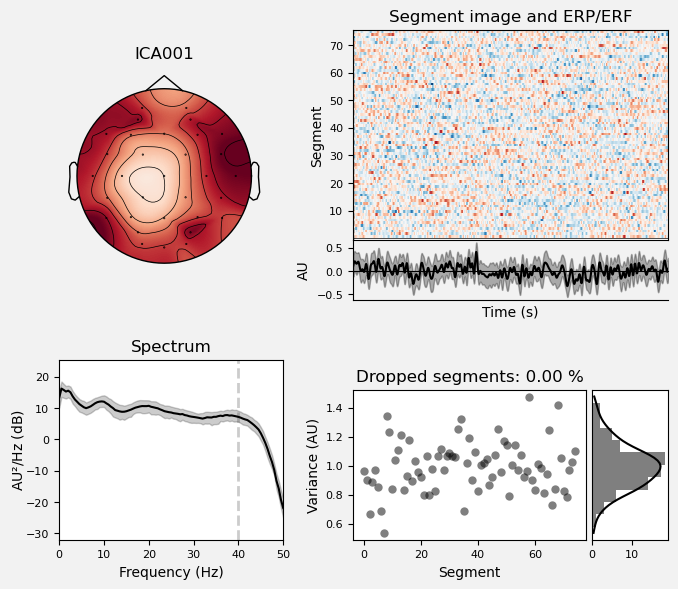

Creating RawArray with float64 data, n_channels=20, n_times=76801
    Range : 0 ... 76800 =      0.000 ...   150.000 secs
Ready.


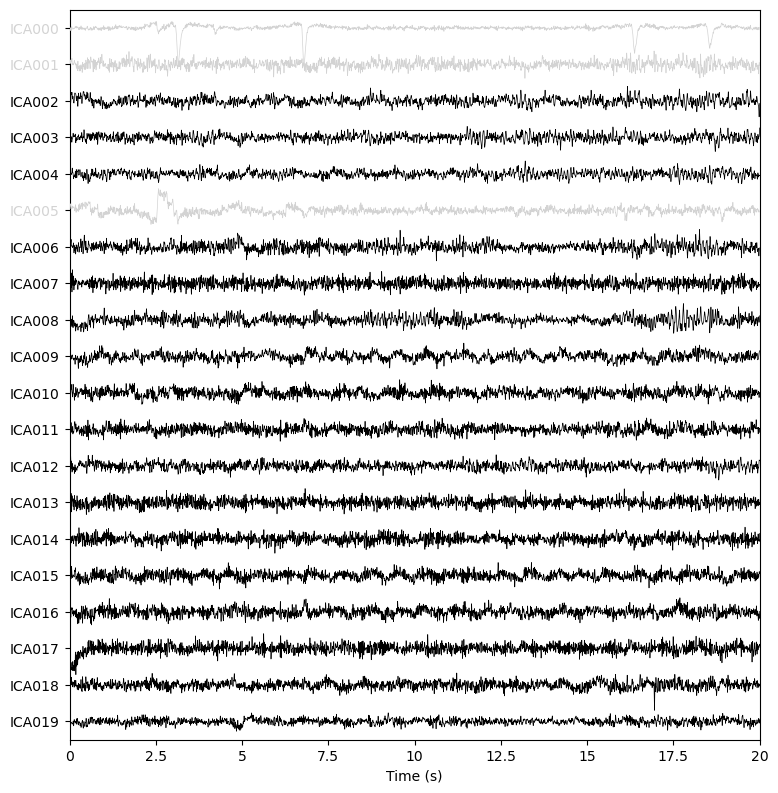

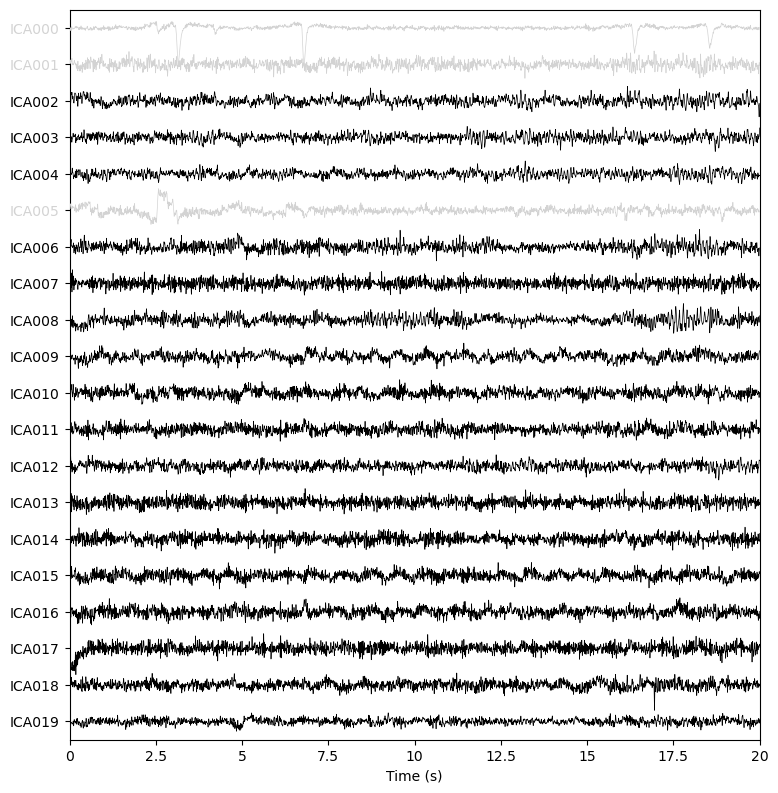

In [31]:
ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name=['Fp2', 'F8'], threshold=1.96)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

# plot diagnostics
ica.plot_properties(raw, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw, show_scrollbars=False)

In [33]:
drop = open(f"{path}drop_on.txt", "r")
exclude_list = drop.read().split(',')
exclude_list = [int(i) for i in exclude_list]
exclude_list

[0]

In [34]:
ica.exclude = exclude_list
ica.exclude

[0]

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components


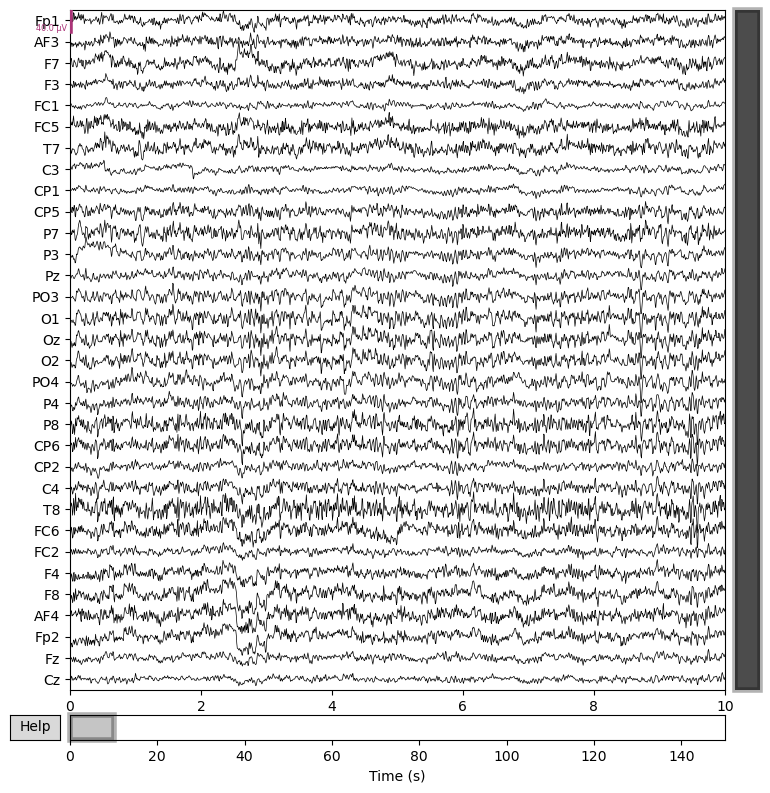

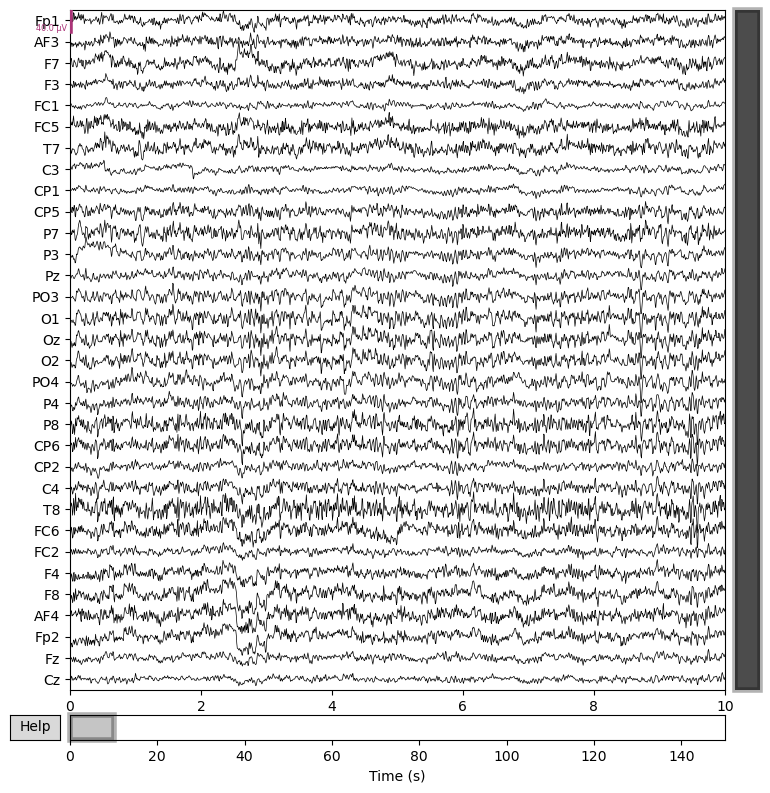

In [35]:
raw_clean = ica.apply(raw.copy(), exclude = ica.exclude)
raw_clean.plot(n_channels = 32)

In [36]:
xRaw = raw_clean.get_data()
len(xRaw[0])

76801

<h2>Calculating Fractal Dimensions</h2>

In [37]:
#len(x_raw)
df_higuchi = pd.DataFrame(columns = raw.ch_names) # Higuchi
df_katz = pd.DataFrame(columns = raw.ch_names) # Katz
df_petrosian = pd.DataFrame(columns = raw.ch_names) # Petrosian
df_spec_ent = pd.DataFrame(columns = raw.ch_names)  # Spectral Entropy
df_perm_ent = pd.DataFrame(columns = raw.ch_names)  # Permutation Entropy

df_svd_ent = pd.DataFrame(columns = raw.ch_names)  # SVD Entropy
df_app_ent = pd.DataFrame(columns = raw.ch_names)  # Approximate Entropy
df_samp_ent = pd.DataFrame(columns = raw.ch_names)  # Sample Entropy
df_hjorth = pd.DataFrame(columns = raw.ch_names)  # Hjorth mobility and complexity
df_num_zerocross = pd.DataFrame(columns = raw.ch_names)  # Number of zero crossings
df_lziv = pd.DataFrame(columns = raw.ch_names)  # LZIV complexity
df_det_fluc = pd.DataFrame(columns = raw.ch_names)  # Detrended Fluctuation


channel_no=0
for row in xRaw: #row === channel_no.
    
    hig_channel_series = []
    katz_channel_series = []
    petrosian_channel_series = []
    spec_ent_channel_series = []
    perm_ent_channel_series = []

    df_svd_ent_channel_series = []
    df_app_ent_channel_series = []
    df_samp_ent_channel_series = []
    df_hjorth_channel_series = []
    df_num_zerocross_channel_series = []
    df_lziv_channel_series = []
    df_det_fluc_channel_series = []
    
    for i in range(512,len(xRaw[0]),256):
        hig_channel_series.append(ant.higuchi_fd(row[i-512:i]))
        katz_channel_series.append(ant.katz_fd(row[i-512:i]))
        petrosian_channel_series.append(ant.petrosian_fd(row[i-512:i]))
        spec_ent_channel_series.append(ant.spectral_entropy(row[i-512:i], sf=1000, method='welch', normalize=True))
        perm_ent_channel_series.append(ant.perm_entropy(row[i-512:i], normalize=True))

        df_svd_ent_channel_series.append(ant.svd_entropy(row[i-512:i], normalize=True))
        df_app_ent_channel_series.append(ant.app_entropy(row[i-512:i]))
        df_samp_ent_channel_series.append(ant.sample_entropy(row[i-512:i]))
        df_hjorth_channel_series.append(ant.hjorth_params(row[i-512:i]))
        df_num_zerocross_channel_series.append(ant.num_zerocross(row[i-512:i]))
        df_lziv_channel_series.append(ant.lziv_complexity(row[i-512:i]))
        df_det_fluc_channel_series.append(ant.detrended_fluctuation(row[i-512:i]))


        
    df_higuchi.iloc[:,channel_no] = hig_channel_series
    df_katz.iloc[:,channel_no] = katz_channel_series
    df_petrosian.iloc[:,channel_no] = petrosian_channel_series
    df_spec_ent.iloc[:,channel_no] = spec_ent_channel_series
    df_perm_ent.iloc[:,channel_no] = perm_ent_channel_series

    df_svd_ent.iloc[:,channel_no] = df_svd_ent_channel_series
    df_app_ent.iloc[:,channel_no] = df_app_ent_channel_series
    df_samp_ent.iloc[:,channel_no] = df_samp_ent_channel_series
    df_hjorth.iloc[:,channel_no] = df_hjorth_channel_series
    df_num_zerocross.iloc[:,channel_no] = df_num_zerocross_channel_series
    df_lziv.iloc[:,channel_no] = df_lziv_channel_series
    df_det_fluc.iloc[:,channel_no] = df_det_fluc_channel_series
    
    #print(len(channel_series))
    channel_no += 1        

/var/folders/0_/ympcrcjj65s8syj_2h5nhmm81btksl/T/ipykernel_70904/2054950658.py:51: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_higuchi.iloc[:,channel_no] = hig_channel_series
/var/folders/0_/ympcrcjj65s8syj_2h5nhmm81btksl/T/ipykernel_70904/2054950658.py:52: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_katz.iloc[:,channel_no] = katz_channel_series
/var/folders/0_/ympcrcjj65s8syj_2h5nhmm81btksl/T/ipykernel_70904/2054950658.py:53: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace

In [38]:
df_higuchi

Fp1       AF3        F7        F3       FC1       FC5        T7  \
0    1.314250  1.314132  1.296044  1.284429  1.164205  1.329974  1.257705   
1    1.302012  1.310854  1.332339  1.262953  1.169227  1.321260  1.241942   
2    1.281137  1.338581  1.313428  1.271667  1.194776  1.304628  1.243594   
3    1.255799  1.295948  1.293668  1.247135  1.160881  1.279557  1.323221   
4    1.258559  1.247612  1.275817  1.244918  1.169946  1.262568  1.295908   
..        ...       ...       ...       ...       ...       ...       ...   
294  1.221636  1.312966  1.298279  1.222478  1.196157  1.250269  1.234789   
295  1.236946  1.312661  1.276371  1.205491  1.192964  1.249828  1.220475   
296  1.216770  1.243939  1.203496  1.208642  1.173171  1.241195  1.205783   
297  1.199863  1.214771  1.181638  1.216583  1.163925  1.246373  1.199980   
298  1.236487  1.243787  1.217436  1.268917  1.178661  1.273881  1.226516   

           C3       CP1       CP5  ...        C4        T8       FC6  \
0    1.218122  1.179355  1.247563  ...  1.219871  1.328728  1.275117   
1    1.189468  1.218702  1.235812  ...  1.237904  1.318075  1.306016   
2    1.193675  1.202168  1.236248  ...  1.255341  1.288474  1.317386   
3    1.197895  1.165282  1.243921  ...  1.213529  1.287171  1.279563   
4    1.188792  1.171787  1.211713  ...  1.183649  1.257648  1.245881   
..        ...       ...       ...  ...       ...       ...       ...   
294  1.190714  1.182790  1.214900  ...  1.194408  1.237767  1.209677   
295  1.203704  1.203352  1.211402  ...  1.227802  1.251342  1.271132   
296  1.243202  1.175778  1.196791  ...  1.290360  1.300564  1.326684   
297  1.217663  1.138114  1.174333  ...  1.230247  1.242114  1.247086   
298  1.195695  1.125644  1.160321  ...  1.197782  1.234618  1.230264   

          FC2        F4        F8       AF4       Fp2        Fz        Cz  
0    1.222386  1.278299  1.295868  1.342612  1.296996  1.205958  1.227185  
1    1.224428  1.273475  1.265743  1.325861  1.283642  1.207789  1.201920  
2    1.268061  1.315380  1.257978  1.265516  1.289360  1.237394  1.236429  
3    1.193501  1.257480  1.256833  1.267201  1.265620  1.192155  1.225674  
4    1.179204  1.223148  1.240424  1.291449  1.228249  1.188738  1.206392  
..        ...       ...       ...       ...       ...       ...       ...  
294  1.183166  1.214851  1.253595  1.258206  1.254967  1.220216  1.172405  
295  1.220939  1.224074  1.233466  1.280057  1.235826  1.215727  1.201512  
296  1.250156  1.254534  1.239266  1.248044  1.233566  1.218419  1.232216  
297  1.195872  1.195555  1.190932  1.201180  1.205925  1.165185  1.208183  
298  1.178084  1.197902  1.192315  1.212277  1.208953  1.175604  1.181750  

[299 rows x 32 columns]

In [39]:
df_det_fluc

Fp1       AF3        F7        F3       FC1       FC5        T7  \
0    1.323896  1.305276  1.381402  1.358690  1.638975  1.361332  1.472683   
1    1.313686  1.322490  1.422603  1.406464  1.665330  1.312711  1.495353   
2    1.348776  1.277933  1.439328  1.390360  1.512546  1.301567  1.509063   
3    1.422608  1.359099  1.405189  1.463599  1.575751  1.390926  1.424605   
4    1.482956  1.442440  1.499721  1.478563  1.625939  1.420180  1.469176   
..        ...       ...       ...       ...       ...       ...       ...   
294  1.428779  1.357892  1.357319  1.408808  1.591832  1.386496  1.448726   
295  1.454370  1.351473  1.357443  1.478445  1.621548  1.385479  1.448776   
296  1.564352  1.504011  1.592321  1.564257  1.599630  1.494899  1.639125   
297  1.591350  1.539661  1.637664  1.536624  1.581377  1.435113  1.594572   
298  1.502918  1.497725  1.523899  1.457776  1.622866  1.406821  1.508264   

           C3       CP1       CP5  ...        C4        T8       FC6  \
0    1.604182  1.604295  1.468470  ...  1.525013  1.323373  1.431677   
1    1.691368  1.558025  1.574962  ...  1.498616  1.326542  1.336850   
2    1.663526  1.508816  1.490862  ...  1.419884  1.299388  1.277734   
3    1.676302  1.511745  1.421674  ...  1.425232  1.315413  1.347325   
4    1.570767  1.516990  1.473313  ...  1.552339  1.370851  1.480384   
..        ...       ...       ...  ...       ...       ...       ...   
294  1.495752  1.545538  1.485493  ...  1.465902  1.405298  1.446200   
295  1.495490  1.489884  1.437625  ...  1.446972  1.416690  1.390125   
296  1.476878  1.494724  1.600448  ...  1.311590  1.356915  1.319330   
297  1.514912  1.593325  1.632633  ...  1.468391  1.469937  1.451158   
298  1.528651  1.645282  1.584514  ...  1.557566  1.474362  1.458263   

          FC2        F4        F8       AF4       Fp2        Fz        Cz  
0    1.455371  1.356424  1.385339  1.283200  1.358129  1.469362  1.511225  
1    1.540908  1.395820  1.433833  1.277066  1.453040  1.555396  1.544707  
2    1.491991  1.291767  1.371077  1.353078  1.391958  1.509988  1.526517  
3    1.532962  1.424383  1.399696  1.347321  1.387814  1.589242  1.475658  
4    1.588034  1.534241  1.540325  1.471705  1.577179  1.633402  1.511422  
..        ...       ...       ...       ...       ...       ...       ...  
294  1.499829  1.444200  1.419350  1.375367  1.431997  1.490393  1.489857  
295  1.497382  1.476528  1.446588  1.353827  1.415967  1.559518  1.522285  
296  1.430599  1.444434  1.480325  1.445032  1.478155  1.508422  1.520697  
297  1.502789  1.513458  1.554995  1.532105  1.529814  1.559804  1.496147  
298  1.554817  1.520422  1.532978  1.510049  1.546009  1.582733  1.507790  

[299 rows x 32 columns]

In [40]:
df_svd_ent

Fp1       AF3        F7        F3       FC1       FC5        T7  \
0    0.466616  0.461424  0.415792  0.447119  0.337655  0.450031  0.424838   
1    0.452566  0.471345  0.400267  0.432504  0.326622  0.454078  0.424616   
2    0.463914  0.508035  0.431340  0.452068  0.389074  0.485024  0.444696   
3    0.411826  0.508133  0.441691  0.446984  0.397197  0.477336  0.472860   
4    0.366015  0.483462  0.354784  0.441705  0.385474  0.429511  0.447428   
..        ...       ...       ...       ...       ...       ...       ...   
294  0.448149  0.504306  0.506251  0.460787  0.362854  0.491925  0.472291   
295  0.447743  0.487908  0.484043  0.424271  0.321806  0.485659  0.452894   
296  0.437572  0.466870  0.435710  0.434667  0.320280  0.472195  0.426243   
297  0.419643  0.455257  0.407819  0.441912  0.373407  0.489826  0.424413   
298  0.397106  0.413988  0.389652  0.414830  0.348564  0.447289  0.421736   

           C3       CP1       CP5  ...        C4        T8       FC6  \
0    0.303980  0.400242  0.453982  ...  0.451919  0.513631  0.470758   
1    0.329682  0.392267  0.429846  ...  0.465853  0.511553  0.485882   
2    0.302208  0.419050  0.447392  ...  0.471970  0.509450  0.513130   
3    0.298478  0.407376  0.457996  ...  0.427931  0.494594  0.446854   
4    0.376527  0.406672  0.461677  ...  0.352832  0.441158  0.350369   
..        ...       ...       ...  ...       ...       ...       ...   
294  0.410763  0.440439  0.458484  ...  0.462204  0.497186  0.460845   
295  0.412429  0.429451  0.464203  ...  0.482609  0.506687  0.507754   
296  0.443195  0.402924  0.435027  ...  0.516318  0.509518  0.525626   
297  0.413819  0.406150  0.409557  ...  0.464835  0.461336  0.467452   
298  0.398348  0.379725  0.402152  ...  0.405966  0.436282  0.428607   

          FC2        F4        F8       AF4       Fp2        Fz        Cz  
0    0.449917  0.431516  0.432766  0.511849  0.394385  0.377464  0.446995  
1    0.434257  0.458826  0.418790  0.498497  0.429195  0.389377  0.431129  
2    0.457440  0.491383  0.464045  0.477459  0.470812  0.402833  0.399416  
3    0.363579  0.403066  0.356322  0.397671  0.347653  0.368776  0.412198  
4    0.326295  0.320470  0.254618  0.322827  0.250963  0.324579  0.350418  
..        ...       ...       ...       ...       ...       ...       ...  
294  0.439162  0.443468  0.456417  0.478650  0.445731  0.407922  0.439747  
295  0.453929  0.465018  0.457304  0.488288  0.460480  0.412336  0.436362  
296  0.464066  0.484924  0.468287  0.483510  0.469975  0.458124  0.435168  
297  0.420014  0.446883  0.440980  0.443360  0.450755  0.422764  0.428676  
298  0.387394  0.411002  0.394322  0.412371  0.408757  0.367612  0.403595  

[299 rows x 32 columns]

In [41]:
df_higuchi.to_csv(f"{path}{subject}_PD_ON_50pct.csv", index=False)
df_katz.to_csv(f"{path}{subject}_PD_ON_katz_50pct.csv", index=False)
df_petrosian.to_csv(f"{path}{subject}_PD_ON_petrosian_50pct.csv", index=False)
df_spec_ent.to_csv(f"{path}{subject}_PD_ON_spec_ent_50pct.csv", index=False)
df_perm_ent.to_csv(f"{path}{subject}_PD_ON_perm_ent_50pct.csv", index=False)

df_svd_ent.to_csv(f"{path}{subject}_PD_ON_svd_ent_50pct.csv", index=False)
df_app_ent.to_csv(f"{path}{subject}_PD_ON_app_ent_50pct.csv", index=False)
df_samp_ent.to_csv(f"{path}{subject}_PD_ON_samp_ent_50pct.csv", index=False)
df_hjorth.to_csv(f"{path}{subject}_PD_ON_hjorth_50pct.csv", index=False)
df_num_zerocross.to_csv(f"{path}{subject}_PD_ON_num_zerocross_50pct.csv", index=False)
df_lziv.to_csv(f"{path}{subject}_PD_ON_lziv_50pct.csv", index=False)
df_det_fluc.to_csv(f"{path}{subject}_PD_ON_det_fluc_50pct.csv", index=False)
